### Collect images

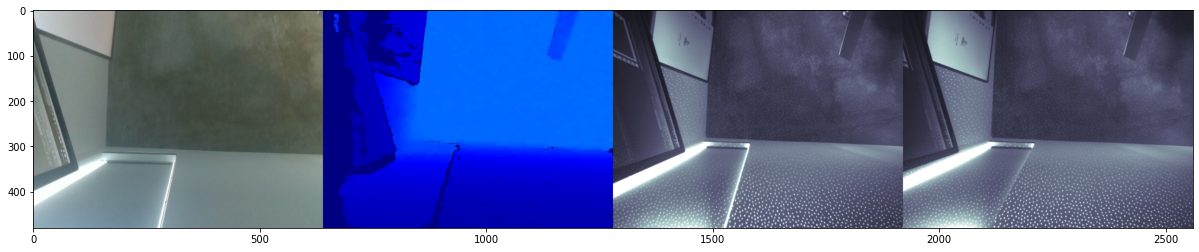

In [51]:
## License: Apache 2.0. See LICENSE file in root directory.
## Copyright(c) 2015-2017 Intel Corporation. All Rights Reserved.

###############################################
##      Open CV and Numpy integration        ##
###############################################

import pyrealsense2 as rs
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Configure depth and color streams
pipeline = rs.pipeline()
config = rs.config()

config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
config.enable_stream(rs.stream.infrared, 1, 640, 480, rs.format.y8, 30)
config.enable_stream(rs.stream.infrared, 2, 640, 480, rs.format.y8, 30)
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)

# Start streaming
pipe_profile = pipeline.start(config)

try:
    # wait for auto exposure
    for i in range(60):
        # Wait for a coherent pair of frames: depth and color
        frames = pipeline.wait_for_frames()

    depth_frame = frames.get_depth_frame()
    color_frame = frames.get_color_frame()
    ir_frame1 = frames.get_infrared_frame(1)
    ir_frame2 = frames.get_infrared_frame(2)
    
    # Convert images to numpy arrays
    depth_image = np.asanyarray(depth_frame.get_data())
    color_image = np.asanyarray(color_frame.get_data())
    ir_image1 = np.asanyarray(ir_frame1.get_data())
    ir_image2 = np.asanyarray(ir_frame2.get_data())

    # Apply colormap on depth image (image must be converted to 8-bit per pixel first)
    depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)
    ir_colormap1 = cv2.applyColorMap(cv2.convertScaleAbs(ir_image1), cv2.COLORMAP_BONE)
    ir_colormap2 = cv2.applyColorMap(cv2.convertScaleAbs(ir_image2), cv2.COLORMAP_BONE)

    depth_colormap_dim = depth_colormap.shape
    color_colormap_dim = color_image.shape
    ir_colormap_dim = ir_colormap1.shape

    # If depth and color resolutions are different, resize color image to match depth image for display
    if depth_colormap_dim != color_colormap_dim:
        resized_color_image = cv2.resize(color_image, dsize=(depth_colormap_dim[1], depth_colormap_dim[0]), interpolation=cv2.INTER_AREA)
    else:
        resized_color_image = color_image

    if depth_colormap_dim != ir_colormap_dim:
        resized_ir_image1 = cv2.resize(ir_colormap1, dsize=(depth_colormap_dim[1], depth_colormap_dim[0]), interpolation=cv2.INTER_AREA)
        resized_ir_image2 = cv2.resize(ir_colormap2, dsize=(depth_colormap_dim[1], depth_colormap_dim[0]), interpolation=cv2.INTER_AREA)
    else:
        resized_ir_image1 = ir_colormap1
        resized_ir_image2 = ir_colormap2

    images = np.hstack((resized_color_image, depth_colormap, resized_ir_image1,resized_ir_image2))

    b,g,r = cv2.split(images)       # get b,g,r
    rgb_img = cv2.merge([r,g,b])    # switch it to rgb
    plt.figure(figsize = (40,4))
    plt.imshow(rgb_img)
    plt.show()


finally:
    # Stop streaming
    pipeline.stop()
    cv2.destroyAllWindows()

In [52]:
cv2.imwrite('Data/Realsense/im0.png', ir_image1)
cv2.imwrite('Data/Realsense/im1.png', ir_image2)
cv2.imwrite('Data/Realsense/Color.png', color_image)

True

### Align to color image using depth map

In [53]:
import pyrealsense2 as rs
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
config.enable_stream(rs.stream.infrared, 1, 640, 480, rs.format.y8, 30)
config.enable_stream(rs.stream.infrared, 2, 640, 480, rs.format.y8, 30)
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
pipe_profile = pipeline.start(config)
for i in range(60):
    frames = pipeline.wait_for_frames()
depth_frame = frames.get_depth_frame()
color_frame = frames.get_color_frame()
ir_frame1 = frames.get_infrared_frame(1)
ir_frame2 = frames.get_infrared_frame(2)

# Intrinsics & Extrinsics
depth_intrin = depth_frame.profile.as_video_stream_profile().intrinsics
color_intrin = color_frame.profile.as_video_stream_profile().intrinsics
depth_to_color_extrin = depth_frame.profile.get_extrinsics_to(color_frame.profile)

# Map depth to color
depth_pixel = [240, 320]   # Random pixel
depth_distance = depth_frame.get_distance(*depth_pixel)
depth_point = rs.rs2_deproject_pixel_to_point(depth_intrin, depth_pixel, depth_distance)
color_point = rs.rs2_transform_point_to_point(depth_to_color_extrin, depth_point)
color_pixel = rs.rs2_project_point_to_pixel(color_intrin, color_point)

pipeline.stop()

In [54]:
ir_frame2.profile.as_video_stream_profile().intrinsics

[ 640x480  p[316.673 238.673]  f[385.014 385.014]  Brown Conrady [0 0 0 0 0] ]

In [55]:
ir_frame2.profile.get_extrinsics_to(ir_frame1.profile)

rotation: [1, 0, 0, 0, 1, 0, 0, 0, 1]
translation: [0.0501799, 0, 0]

In [56]:
385.014 * 0.0501799 / 10

1.93199640186

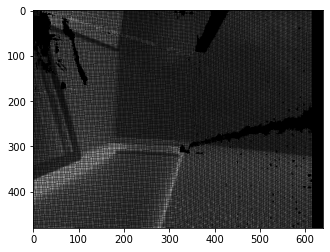

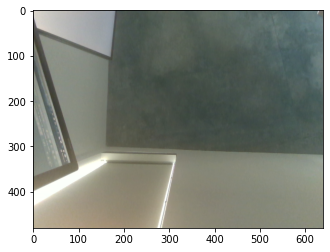

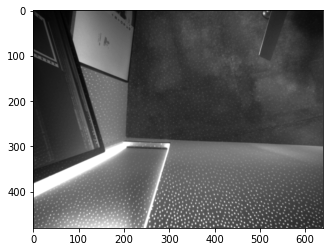

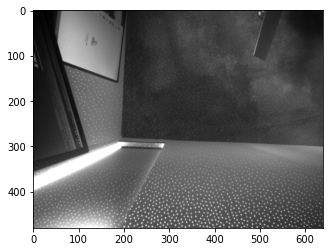

In [57]:
ir_image = np.asanyarray(ir_frame1.get_data())
result = np.zeros((np.asanyarray(color_frame.get_data()).shape[:2]))
for j in range(result.shape[0]):
    for i in range(result.shape[1]):
        # print('i, j', (i, j))
        depth_distance = depth_frame.get_distance(i, j)
        depth_point = rs.rs2_deproject_pixel_to_point(depth_intrin, [i, j], depth_distance)
        color_point = rs.rs2_transform_point_to_point(depth_to_color_extrin, depth_point)
        color_pixel = rs.rs2_project_point_to_pixel(color_intrin, color_point)
        # print('color coord', color_pixel)
        color_x = int(np.rint(color_pixel[0]))
        color_y = int(np.rint(color_pixel[1]))
        # print('color coord', (color_x, color_y))
        if 0 <= color_x < result.shape[0] and \
           0 <= color_y < result.shape[1]:
            result[color_x, color_y] = ir_image[i, j]

plt.imshow(result, 'gray')
plt.show()
plt.imshow(np.asanyarray(color_frame.get_data()))
plt.show()
plt.imshow(np.asanyarray(ir_frame1.get_data()), 'gray')
plt.show()
plt.imshow(np.asanyarray(ir_frame2.get_data()), 'gray')
plt.show()

### Align all frames to the depth frame

In [20]:
import pyrealsense2 as rs
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
config.enable_stream(rs.stream.infrared, 1, 640, 480, rs.format.y8, 30)
config.enable_stream(rs.stream.infrared, 2, 640, 480, rs.format.y8, 30)
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
pipe_profile = pipeline.start(config)

# Create an align object
# rs.align allows us to perform alignment of depth frames to others frames
# The "align_to" is the stream type to which we plan to align depth frames.
align_to = rs.stream.depth
align = rs.align(align_to)

for i in range(60):
    frames = pipeline.wait_for_frames()

# Align to depth frame
aligned_frames = align.process(frames)

# Get aligned frames
depth_frame = aligned_frames.get_depth_frame()
color_frame = aligned_frames.get_color_frame()
ir_frame1 = aligned_frames.get_infrared_frame(1)
ir_frame2 = aligned_frames.get_infrared_frame(2)

pipeline.stop()

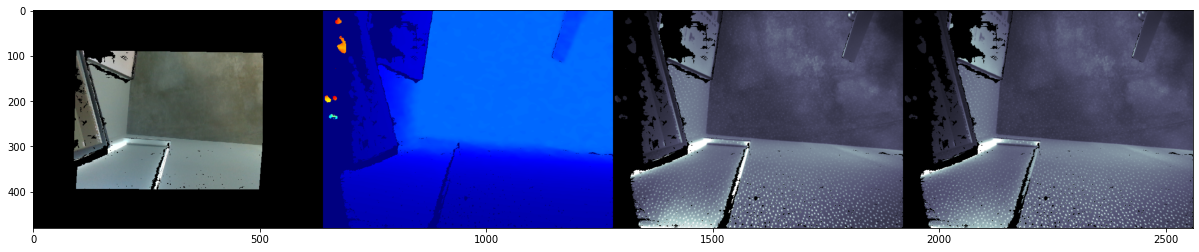

In [21]:
# Convert images to numpy arrays
depth_image = np.asanyarray(depth_frame.get_data())
color_image = np.asanyarray(color_frame.get_data())
ir_image1 = np.asanyarray(ir_frame1.get_data())
ir_image2 = np.asanyarray(ir_frame2.get_data())

# Apply colormap on depth image (image must be converted to 8-bit per pixel first)
depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)
ir_colormap1 = cv2.applyColorMap(cv2.convertScaleAbs(ir_image1), cv2.COLORMAP_BONE)
ir_colormap2 = cv2.applyColorMap(cv2.convertScaleAbs(ir_image2), cv2.COLORMAP_BONE)

depth_colormap_dim = depth_colormap.shape
color_colormap_dim = color_image.shape
ir_colormap_dim = ir_colormap1.shape

# If depth and color resolutions are different, resize color image to match depth image for display
if depth_colormap_dim != color_colormap_dim:
    resized_color_image = cv2.resize(color_image, dsize=(depth_colormap_dim[1], depth_colormap_dim[0]), interpolation=cv2.INTER_AREA)
else:
    resized_color_image = color_image

if depth_colormap_dim != ir_colormap_dim:
    resized_ir_image1 = cv2.resize(ir_colormap1, dsize=(depth_colormap_dim[1], depth_colormap_dim[0]), interpolation=cv2.INTER_AREA)
    resized_ir_image2 = cv2.resize(ir_colormap2, dsize=(depth_colormap_dim[1], depth_colormap_dim[0]), interpolation=cv2.INTER_AREA)
else:
    resized_ir_image1 = ir_colormap1
    resized_ir_image2 = ir_colormap2

images = np.hstack((resized_color_image, depth_colormap, resized_ir_image1,resized_ir_image2))

b,g,r = cv2.split(images)       # get b,g,r
rgb_img = cv2.merge([r,g,b])    # switch it to rgb
plt.figure(figsize = (40,4))
plt.imshow(rgb_img)
plt.show()